In [ ]:
#@title 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/computer-vision-um/cv-um-2021/trabajo-final/


# Ejercicio 2.1: Face Detection

Tal como se explica en la letra del obligatorio final en este ejercicio es necesario implementar desde cero una solucion para detección de caras. Se proveen datos de entrenamiento y es necesario implementar su propio algoritmo de sliding window para entrenar un clasificador. Todo el código necesario para comenzar a trabajar está provisto en este notebook.


\**En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet. Siempre y cuando **no se usen para resolver explicitamente lo que pide el ejercicio** y al código sacado de interenet le agreguen el link en comentarios de donde fue sacado ese código.*



##### Imports necesarios

In [1]:
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn 
import sklearn.neighbors
import matplotlib.pyplot as plt
import pickle
from evaluation import evaluate_detector, precision_and_recall, interpolated_average_precision
import sys
from image_utils import non_max_suppression


### Funciones Provistas



#### Feature Extractors 

Para resolver el ejercicio van a tener que implementar las funciones `extract_hog_features` y `extract_lbp_features`

In [2]:
class FeatureExtractors(Enum):
		MiniImage = 1
		HOG = 2
		LBP = 3

def extract_features(method, img):
	'''Switch between Feature extraction Methods'''

	image_representation = []

	if method == FeatureExtractors.MiniImage:
		image_representation = extract_mini_image_features(img)
	elif method == FeatureExtractors.HOG:
		image_representation = extract_hog_features(img)
	elif method == FeatureExtractors.LBP:
		image_representation = extract_lbp_features(img)	
	
	return image_representation

def extract_mini_image_features(img,resize_size=(64,64)):
	resized_image = cv2.resize(img,resize_size)
	image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
	return image_representation
  
def extract_lbp_features(img):
  return []

def extract_hog_features(img):
  return []


   

#### Data loader

In [3]:
def load_training_data(training_positive_dir,trainign_negative_dir, feature_extractor=FeatureExtractors.MiniImage):
    ''' Function for loading loading training data from positive and negative examples
    '''
    positive_img_files = sorted(glob(training_positive_dir + '/*'))
    negative_img_files = sorted(glob(trainign_negative_dir + '/*'))
    #comment these lines for loading all data
    #change these lines for increasing the amount of data
    positive_img_files = positive_img_files[:100]
    negative_img_files = negative_img_files[:200]

    training_data = []
    training_labels = []
    
    print('##Loading {} positive face images'.format(len(positive_img_files)))
    for img in positive_img_files:
        image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(1)
    
    print('##Loading {} negative face images'.format(len(negative_img_files)))
    for img in negative_img_files:
        image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(0)   
    
    training_data = np.asarray(training_data)
    training_labels = np.asarray(training_labels)
    return training_data, training_labels

def load_validation_data(validation_data_dir):

    validation_image_files = sorted(glob(validation_data_dir + '/*'))
    val_images = []
    for img_file in validation_image_files:
        image = cv2.imread(img_file,cv2.IMREAD_COLOR)
        val_images.append(image)

    return val_images 

#### Sliding Window


In [4]:
def sliding_window(image, window_size, scale, stride):
    [image_rows, image_cols] = image.shape;
    window_rows = window_size[0];
    window_cols = window_size[1];

    patches = np.zeros((window_rows, window_cols,5));
    bbox_locations = np.zeros((5,4))
    r = np.random.randint(0,image_rows-window_rows,5); # Sample top left position
    c = np.random.randint(0,image_cols-window_cols,5);
    for i in range(0,5):
        patches[:,:,i] = image[r[i]:r[i]+window_rows, c[i]:c[i]+window_cols];
        bbox_locations[i,:] = [r[i],c[i],window_rows,window_cols]; # top-left y,x, height, width


    return patches, bbox_locations

##### Metodos Auxiliares


In [5]:
def show_image_with_bbox(image,bboxes,draw_GT=True):
    GT = [82,91,166,175]
    if draw_GT:
        cv2.rectangle(image, (GT[0],GT[1]), (GT[2],GT[3]), (0, 0, 255), 2)

    for bbox in bboxes:
        if len(bbox) == 4:   
            top_left = (int(bbox[0]),int(bbox[1]))
            bottom_right = (int(bbox[0])+ int(bbox[2]),int(bbox[1])+int(bbox[3]))
            cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(image[...,::-1])
    plt.axis('off')
    plt.show()

### Ubicación de los datos ###

In [6]:
data_dir='./data'
face_detection_dir = os.path.join(data_dir, 'face_detection')
training_faces_dir = os.path.join(face_detection_dir,'cropped_faces')
negative_examples_training_dir = os.path.join(face_detection_dir,'non_faces_images','neg_cropped_img')
validation_faces_dir = os.path.join(face_detection_dir,'val_face_detection_images')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

## Entrenar Modelo y Face Detection


### Cargar Datos de Entrenamiento ###

In [7]:
#Modify data_loader.py to load more training data
training_data, trainig_labels = load_training_data(training_faces_dir,negative_examples_training_dir, FeatureExtractors.MiniImage)
# You can save traninig_data and labels on nunmpy files to avoid processing data every time. 

##Loading 100 positive face images
##Loading 200 negative face images


### Load Validation Data ###

In [8]:
validation_data = load_validation_data(validation_faces_dir)

### Entrenar un clasificador utilizando los datos de entrenamiento ## 
1. Una vez los datos de entrenamiento han sido cargados es necesario entrenar su propio clasificador 
2. Como solución inicial se utiliza un clasificador KNN pero para tener mejores resultados es posible entrenar un SVM. Se puede utilizar el [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) de sklearn a modo de ejemplo
3. Entrenar su clasificador y guardarlo en el archivo `face_detector`

In [9]:
knn_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)

In [10]:
knn_classifier.fit(training_data,trainig_labels)

KNeighborsClassifier(n_neighbors=3)

#### Guardar el modelo entrenado ##

In [11]:
pickle.dump(knn_classifier,open('./face_detector', 'wb'))

#### Cargar el Modelo entrenado 

In [12]:
classifier = pickle.load(open('./face_detector','rb'))

### Do the sliding window and Visualize Results ###
1. In this part you need to perform the sliding window and score the probabilty of each patch of being a face and select the highest probability patches. 
    1a. Program you own sliding window in 'img_utils' file.
    1b. Extract Features and classify each patch with your own classifier. 
2. Do non-max suppression to select the target face patch with best probability (This is provided in 'img_utils')
3. Visualize Detection with Ground Throuth Bounding Box ('Code for Visualization is Provided')

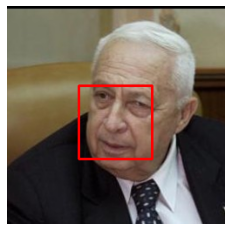

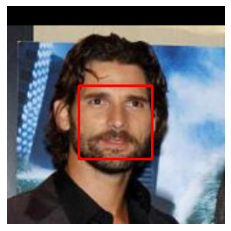

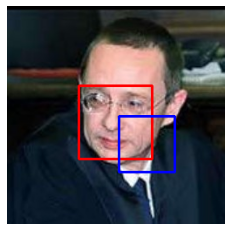

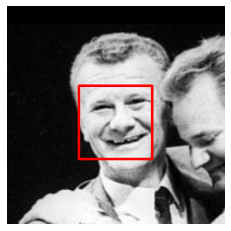

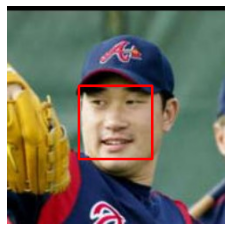

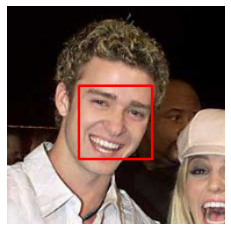

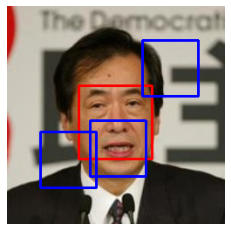

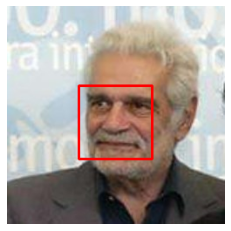

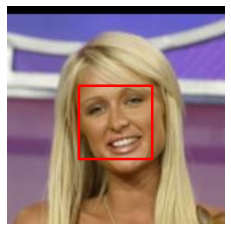

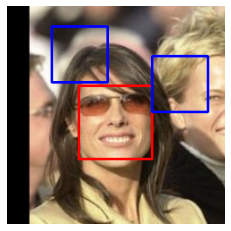

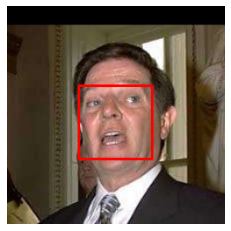

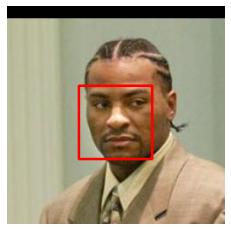

In [13]:
window_size = [64, 64]
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5
validation_data = load_validation_data(validation_faces_dir)
for img in validation_data:
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,1,32)

    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.MiniImage, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    ## Get prediction label for each sliding window patch
    labels = classifier.predict(patches_feature_representation)
    ## Get score for each sliding window patch
    scores = classifier.predict_proba(patches_feature_representation)
    ## Positive Face Probabilities
    face_probabilities = scores[:,1]
    face_bboxes = bbox_locations[face_probabilities>threshold_p]
    face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
    # Do non max suppression and select strongest probability box
    [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites,0.3)
    show_image_with_bbox(img, selected_bbox)


### Evaluate Detector ###

In [14]:
total_true_positives = []
total_real_positives = []
total_positive_predictions = []
window_size = [64, 64]
for subject_folder in sorted(glob(validation_raw_faces_dir + '/*')):
    for img in sorted(glob(subject_folder + '/*.jpg')):
        gray_image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        patches, bbox_locations = sliding_window(gray_image,window_size,1,32)
        ## You need to extract features for every patch (same features you used for training the classifier)
        patches_feature_representation = []
        for i in range(patches.shape[2]):
            patch_representation = extract_features(FeatureExtractors.MiniImage, patches[:,:,i])
            patches_feature_representation.append(patch_representation)
        patches_feature_representation = np.asarray(patches_feature_representation)
        ## Get score for each sliding window patch
        scores = classifier.predict_proba(patches_feature_representation)
        ## Positive Face Probabilities
        face_probabilities = scores[:,1]
        #[labels, acc, prob] = predict([],patches_feature_representation, clasifier)
        ## Positive Face Probabilities
        #face_probabilities = np.asarray(prob)
        #face_probabilities = face_probabilities.T[0]
        
        [ detected_true_positives, image_real_positives, detected_faces ] = evaluate_detector( bbox_locations, face_probabilities);
        total_true_positives.append(detected_true_positives)
        total_real_positives.append(image_real_positives)
        total_positive_predictions.append(detected_faces)
        
total_true_positives = np.asarray(total_true_positives)
total_real_positives = np.asarray(total_real_positives)
total_positive_predictions = np.asarray(total_positive_predictions)
        
        


### Evaluation Results 

In [15]:
precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_positive_predictions)

(0.0, 1.1)

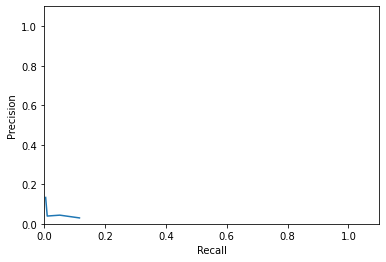

In [16]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)

In [17]:
ap = interpolated_average_precision(recall,precision)

In [18]:
print('Detection Average Precision is {}'.format(ap))

Detection Average Precision is [0.00068906]
